# TSP problem

In [1]:
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
from icecream import ic
import functools
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import math

Let's import one of the available datasets of cities by choosing the desired `CHOSEN_SET` from in `{0,1,2,3,4}` (*4 is the biggest*).

In [2]:
CITIES_ROOTPATH = "cities/"
CITIES=["vanuatu.csv", "italy.csv", "russia.csv", "us.csv", "china.csv"]

In [3]:
# uncomment one 
CHOSEN_SET = 0 # vanuatu
#CHOSEN_SET = 1 # italy
#CHOSEN_SET = 2 # russia
#CHOSEN_SET = 3 # us
#CHOSEN_SET = 4 # china

cities = pd.read_csv(CITIES_ROOTPATH+CITIES[CHOSEN_SET],header=None, names=["name","lat","lon"])
NUM_CITIES = len(cities);

Now i define the dist. matrix with *geopy*, identifying at each `[i,j]` position the distance in *km* between cities at indexes `i` and `j`.

In [4]:
dist_matrix = np.zeros((len(cities), len(cities)))
for c1, c2 in combinations(cities.itertuples(), 2):
    dist_matrix[c1.Index, c2.Index] = dist_matrix[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

Finally, i defined a random number generator initialized with a seed that is dependent on the problem configuration, in order to control the pseudo-randomness allowing reproducible execution.

In [5]:
# I initialize the rng with repeatable values provided by the instance:
# first 10 cities in list format, rounded to int and in absolute value
rng = np.random.Generator(np.random.PCG64(cities.lat.head(10).astype(int).abs().to_list()))

## Definitions & Utilities

Let's define some utilities that will be used in different phases: indeed we decide
- **encoding/genome**: i used a one-time encoding in a circular list of integers:
    - the solution is encoded in the array of indexes of cities ordered in the related visit order
    - the whole length of the **circular path** is composed by the sum of all the paths that are made from the city in an item to the city in the next item;
    - consider also the adjaceny of the first item to the last, due to the list circularity, allowing to close the path as requested by the problem
- **cost**: cost is computed on the encoded solution (*genome*) simply by iterating on the solution array, accumulating at each iteration `i` the distance from city at index `i` to city at index `i+1` of the solution; when `i=len(cities)`, the "*next city*" will be the first item, closing the path. This result in having as cost the length of the whole path in *km*.
- **fitness**: fitness is considered as the negative cost, as we only want to minimize the total length of the whole path.

> Notice that in this encoding there is no meaning in absolute position of indexes in the array, instead all the phenotype traits are encoded in relative positioning of items and in their closeness.

In [6]:
GENOME_SIZE = NUM_CITIES

def hprint(*args,**kwargs):
    """Equivalent to print, but highlighted."""
    print('\x1b[1;30;42m' + args[0] + '\x1b[0m',*args[1:],**kwargs)

def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

@counter
def genome_cost(genome:np.ndarray):
    """Compute the cost for the given solution/genome."""
    total_len=0
    for cpair in zip(genome,np.roll(genome,-1)):
        total_len += dist_matrix[cpair[0], cpair[1]]
    return total_len

def genome_fitness(genome:np.ndarray):
    return -genome_cost(genome)

def randomGenome(sz):
    """Retrieves a random genome of the given size `sz`."""
    genome = np.arange(sz)
    rng.shuffle(genome)
    return genome

## Greedy Approach
First, let's try with a greedy approach, picking at each step the closest city to the first and the last one: indeed, as i used a circular list, i decided to proceed composing the solution by picking alternatively the closest city to the first and the last cities in the current solution.
- push front closest to previous front
- push back closest to previous back


In [7]:
to_be_visited = [i for i in range(NUM_CITIES)]
greedy_solution = [to_be_visited.pop(0)]
# in each iteration, add one at the top and one at the bottom of the array
lgs = len(greedy_solution)

while lgs!=NUM_CITIES:
    to_be_visited.sort(key=lambda i: dist_matrix[i,greedy_solution[0]])
    greedy_solution.insert(0,to_be_visited.pop(0))
    lgs+=1
    
    if lgs!=NUM_CITIES:
        to_be_visited.sort(key=lambda i: dist_matrix[i,greedy_solution[lgs-1]])
        greedy_solution.insert(lgs,to_be_visited.pop())
        lgs+=1
    
greedy_solution = np.array(greedy_solution)
ic(genome_cost(greedy_solution))
ic(genome_cost(randomGenome(GENOME_SIZE)));

ic| genome_cost(greedy_solution): np.float64(1714.8219128836638)
ic| genome_cost(randomGenome(GENOME_SIZE)): np.float64(1573.7657465927193)


## GA implementation
The greedy approach by itself is not able to provide a good solution, as shown by comparing it with a randomly obtained solution: indeed, connecting closest cities at each step is not a global optimization, and it is a good strategy only for a very small number of cities.

However, it can be used as a starting point for a *GA approach*.
Let's consider *genomes* defined as above, using them to run a genetic algorithm to optimize the search.
I my implementation i only tweak on permutation, as:
- the problem is meaningless if not all item are taken
- there is no meaning in repeated visit of nodes, as the direct link should be the fastest being the graph *fully conected*

First, let's define the class `Individual`, in order to wrap the genomes in a convenient class; the class also automatically manages the fitness, that is automatically updated when modifying the genome through the setter method `.setGenome()`: this is convenient as teh fitness of individuals is always computed at least one time, and often many times, so it saves re-computations by caching the result in a local variable.

> It is strognly suggested to access genome and variables through dedicated getters and setters methods.

In [8]:
class Individual:
    __genome: np.ndarray=None
    __fitness:float=None

    def __init__(self,genome:np.ndarray=None,fitness=None):
        if genome is not None:
            if fitness is not None:
                self.__genome = genome.copy()
                self.__fitness = fitness
            else:
                self.setGenome(genome)

    @staticmethod
    def getRandom():
        return Individual(randomGenome(GENOME_SIZE))
    
    
    def setGenome(self,genome:np.ndarray):
        self.__genome = genome.copy()
        self.__fitness = genome_fitness(self.__genome)

    def genome(self)->np.ndarray:
        return self.__genome.copy()

    def fitness(self):
        return self.__fitness
    
    def copy(self):
        return Individual(self.__genome,self.__fitness)

Now i use the `Individual` class to define on it my mutation operators; i defined 3 different mutation operators:
- `swap_mutation(parent,step=1)`: choose a locus and swap its allele to the one at distance provided by the parameter `step` (considering circularity); `abs(step)` must be l.e. the size of the parent genome;
- `inverse_mutation(parent,size=3)`: randomly choose 2 loci where the region defined by them (them included, also considering circularity) has size=`size` and invert the alleles contained by them; require a `size` parameter, representing the size of the inverted region, that must be between `2` and the size of the parent genome;
- `insertion_mutation(parent,num_skips=2)`: choose a random locus and move its alleles near another, shifting the others to provide insertion; require a `num_skips` parameter, representing the number of loci skipped (*going left*) by the moving allele;

In [9]:
def swap_mutation(parent:Individual,*,step=1):
    parent_genome = parent.genome()
    if step==0:
        return parent.copy()
    elif abs(step)>=parent_genome.size:
        raise Exception(f"Cannot use a step of {step} in a {parent_genome.size}-long array")
    loc1 = rng.integers(parent_genome.size)
    loc2 = loc1+step
    if loc2>parent_genome.size-1:
        loc2 = loc2 % parent_genome.size # circular index
    parent_genome[loc1],parent_genome[loc2] = parent_genome[loc2],parent_genome[loc1]
    return Individual(parent_genome)

def inverse_mutation(parent:Individual,size=3):
    parent_genome = parent.genome()
    if size<2:
        return parent.copy()
    elif size > parent_genome.size:
        raise Exception(f"Inverting size {size} cannot be applied to a {parent_genome.size}-long array")
    
    """
    Instead of randomly choosing the first locus, i provide circularity by providing a random roll to the array and then operating on it:
    in this case, choosing as 0 the first index is equivalent; finally the original order is restored by reversing the roll before returning;
    """
    rollnum = rng.integers(parent_genome.size-1) 
    circ_genome = np.roll(parent_genome,-rollnum)

    # select the subset of the given size, invert it and substitute it to the genome in the curent rotation
    last_ind = size-1 # last index is simply size-1 (sure not to go out of borders)
    inv_subset = circ_genome[:last_ind+1][::-1] 
    circ_genome[:last_ind+1] = inv_subset

    # restore original order and return
    final_genome = np.roll(circ_genome,rollnum)
    return Individual(final_genome)

def insertion_mutation(parent:Individual,num_skips=2):
    parent_genome = parent.genome()
    if num_skips<1:
        return parent.copy()
    elif num_skips>=parent_genome.size:
        raise Exception(f"It is impossible to skip more than {parent_genome.size-1} items for insertion in a {parent_genome.size}-long array; you tried skipping {num_skips}")
    
    # perform removal
    rem_ind = rng.integers(parent_genome.size) # random index to remove from
    tmp = parent_genome[rem_ind] # save value
    parent_genome = np.delete(parent_genome,rem_ind)

    # perform insertion and return
    ins_ind = rem_ind-num_skips
    if ins_ind<0:
        ins_ind = parent_genome.size+ins_ind
    parent_genome = np.insert(parent_genome,ins_ind,tmp)
    return Individual(parent_genome)

Now i do the same, using the `Individual`, but to define on it my **xover** operators; i defined 3 different mutation operators:
- `PMX(parent1,parent2,slice_size=2)`: Partially mapped crossover, with given size=`slice_size` (that must be between l.e. than the size of the genome of the parents) representing the size of the contiguous slice fully copied from the first parent;
- `OX(parent1,parent2,slice_size=2)`: Order Crossover, with given size=`slice_size` (that must be between l.e. than the size of the genome of the parents) representing the size of the contiguous slice fully copied from the first parent;
- `CX(parent1,parent2)`: Cicle Crossover;

In [10]:
def PMX(parent1:Individual,parent2:Individual,*,slice_size=2):
    sz = slice_size
    pg1 = parent1.genome()
    pg2 = parent2.genome()
    if sz<1:
        raise Exception(f"Slice size {sz} cannot be applied to {pg1.size}-long arrays, must be between 1 and {pg1.size}")
    elif pg1.size != pg2.size:
        raise Exception(f"Length of the genomes of the 2 parents must match, instead you provided parents with g.l. {pg1.size} and {pg2.size}")
    elif sz > pg1.size:
        raise Exception(f"Slice size {sz} cannot be applied to {pg1.size}-long arrays, must be between 1 and {pg1.size}")
    
    psz = pg1.size
    
    """
    Instead of randomly choosing the first locus, i provide circularity by providing a random roll to the array and then operating on it:
    in this case, choosing as 0 the first index is equivalent; finally the original order is restored by reversing the roll before returning;
    """
    rollnum = rng.integers(psz-1) 
    rot_pg1 = np.roll(pg1,-rollnum)
    rot_pg2 = np.roll(pg2,-rollnum)

    rot_sg = rot_pg1.copy() # create son genome (rotated)

    # select the subset of the given size from the first parent and create the mapping
    mapping = dict()
    last_ind = sz-1 # last index is simply sz-1 (sure not to go out of borders)
    for i in range(last_ind+1):
        mapping[rot_pg1[i]]=rot_pg2[i]
    for i in range(last_ind+1,psz):
        rot_sg[i]=rot_pg2[i]
        while rot_sg[i] in mapping:
            rot_sg[i] = mapping[rot_sg[i]]
    
    son_genome = np.roll(rot_sg,rollnum)
    return Individual(son_genome)

def OX(parent1:Individual,parent2:Individual,slice_size=2):
    sz = slice_size
    pg1 = parent1.genome()
    pg2 = parent2.genome()
    if sz<1:
        raise Exception(f"Slice size {sz} cannot be applied to {pg1.size}-long arrays, must be between 1 and {pg1.size}")
    elif pg1.size != pg2.size:
        raise Exception(f"Length of the genomes of the 2 parents must match, instead you provided parents with g.l. {pg1.size} and {pg2.size}")
    elif sz > pg1.size:
        raise Exception(f"Slice size {sz} cannot be applied to {pg1.size}-long arrays, must be between 1 and {pg1.size}")
    
    psz = pg1.size
    
    """
    Instead of randomly choosing the first locus, i provide circularity by providing a random roll to the array and then operating on it:
    in this case, choosing as 0 the first index is equivalent; finally the original order is restored by reversing the roll before returning;
    """
    rollnum = rng.integers(psz-1) 
    rot_pg1 = np.roll(pg1,-rollnum)
    rot_pg2 = np.roll(pg2,-rollnum)

    rot_sg = rot_pg1.copy() # create son genome (rotated)

    taken = rot_pg1[:sz] # elements copied from p1
    offset = sz # start copying the rest from p2 starting from the first locus out of the copied section
    idx2=0
    for i in range(offset,psz):
        while idx2<psz and rot_pg2[idx2] in taken:
            idx2+=1
        if idx2<psz:
            rot_sg[i] = rot_pg2[idx2]
            idx2+=1
        else:
            break

    son_genome = np.roll(rot_sg,rollnum)
    return Individual(son_genome)

def CX(parent1:Individual,parent2:Individual):
    pg1 = parent1.genome()
    pg2 = parent2.genome()
    psz = pg1.size
    
    son_genome = pg1.copy()
    
    pos_g1 = []
    id1=None
    while id1!=0:
        if id1 is None:
            id1=0
        pos_g1.append(id1)

        a2=pg2[id1] # p2 allele a2 corresponding to pg2[id1]
        id1=np.where(pg1==a2)[0][0] # index id1 such that pg1[id1]==a2 allele from p2

    idx2=0
    pg2 = np.delete(pg2,pos_g1)
    for i in range(psz):
        if i not in pos_g1:
            son_genome[i] = pg2[idx2]
            idx2+=1

    return Individual(son_genome)    


### Hybrid Operators & Wrapping Classes
Finally, i further define `Mutator` and `Recombinator` classes, that automatically wraps the all the relative method in once:
- `Mutator` wraps all the mutation operators
- `Recombinator` wraps all the recombination operators

In [11]:
class Mutator:
    __genome_size=None
    __mutators=list()
    __index=0

    def __init__(self,genome_size):
        self.__genome_size=genome_size
        """ For each function we provide the name and the list of parameters;
         each parameter is provided in a dictionary form where for the name of each parameter is provided
         the tuple contaning (minval,maxval) for the random generation, with maxval excluded """
        self.__mutators = [(swap_mutation,{"step":(1,self.__genome_size)}),(inverse_mutation,{"size":(2,self.__genome_size+1)}),(insertion_mutation,{"num_skips":(1,self.__genome_size)})]
    
    def mutate(self,parent,*,strength_perc=100):
        mut = self.__mutators[self.__index]
        mut_func = mut[0]
        mut_params = mut[1].copy()
        for k in mut_params:
            mut_params[k] = rng.integers(mut_params[k][0], mut_params[k][0]+math.ceil((mut_params[k][1]-mut_params[k][0])*strength_perc/100))
        self.__index+=1
        if self.__index>=len(self.__mutators):
            self.__index=0
        return mut_func(parent,**mut_params)

    def __call__(self, *args, **kwds):
        return self.mutate(*args, **kwds)
    

class Recombinator:
    __genome_size=None
    __recombinators=list()
    __index=0

    def __init__(self,genome_size):
        self.__genome_size=genome_size
        """ For each function we provide the name and the list of parameters;
         each parameter is provided in a dictionary form where for the name of each parameter is provided
         the tuple contaning (minval,maxval) for the random generation, with maxval excluded """
        self.__recombinators = [(PMX,{"slice_size":(1,self.__genome_size+1)}),(OX,{"slice_size":(1,self.__genome_size+1)}),(CX,dict())]
    
    def recombinate(self,p1,p2,*,stength_perc=100):
        rec = self.__recombinators[self.__index]
        rec_func = rec[0]
        rec_params = rec[1].copy()
        for k in rec_params:
            rec_params[k] = rng.integers(rec_params[k][0], rec_params[k][0]+math.ceil((rec_params[k][1]-rec_params[k][0])*stength_perc/100))
        self.__index+=1
        if self.__index>=len(self.__recombinators):
            self.__index=0
        return rec_func(p1,p2,**rec_params)

    def __call__(self, *args, **kwds):
        return self.recombinate(*args, **kwds)
    
    
MOP = Mutator(GENOME_SIZE)
XOP = Recombinator(GENOME_SIZE)


### Parent Selection

Let's define parent selection function: i chose to use *tournament selection*, selecting a given number of individuals and then choosing the fittest one as a parent.

The `tau` parameter represent the number of individuals picked with substitution to create the pool to draw the winner from: different values of it allows to choose different levels of selective pressure.


In [12]:
def parent_selection(population,*,tau=3):
    """ Perform tournament selection on `population`, by randomly picking `tau` individuals,
     one at the time and with replacement, choosing then the fittest **one** """
    candidates = sorted(np.random.choice(population, tau), key=lambda e: e.fitness(), reverse=True)
    return candidates[0]

### Parameters

Finally, before running the algorithm, let's define all the parameters used in order to have a known and precise configuration.

Almost all parameters are linearly-dependent on `POPULATION_SIZE`, the first parameter defined, that can be dimensioned with a logarithmic or linear relation to the `GENOME_SIZE`.

Indeed, even if initially a linear dependency (3x) was used for the `POPULATION_SIZE-GENOME_SIZE` relationship in order to have the complexity of the model (*defined by parameters*) proportional to genome size, then i switched to a non-linear one (*log*) due to huge computational times, cutting computational time for huge genomes at the expenses of the global optimization.

However, if accuracy needs to be maximized, it is sufficient to switch the relationships by commenting/uncommenting the related 2 lines, considering that the 2 alternatives are fine tuned (*numbers in the log relationship*) to provide consistent results for small datasets.

In [13]:
ic(GENOME_SIZE)

""" Make population proportional non-linearly to GENOME_SIZE using the log
    values 0.1 and 1.006 have been fine tuned by switching from linear proportion to
    log proportion to reduce overhead for big genomes, keeping low genomes accurate"""
# choose: log (faster) vs linear (more accurate)
POPULATION_SIZE = math.ceil(0.6*math.log(0.1*GENOME_SIZE+1,1.006))
#POPULATION_SIZE = 3*GENOME_SIZE

ic(POPULATION_SIZE)

"""Make Offspring proportional to POPULATION by the constant K_OFFPOP"""
K_OFFPOP = 0.4 
OFFSPRING_SIZE = math.floor(POPULATION_SIZE*K_OFFPOP)
# if OFFSPRING_SIZE << POPULATION_SIZE => more Steady-State model
# if OFFSPRING_SIZE >> POPOLUTION_SIZE => more Generational model
ic(OFFSPRING_SIZE)

"""Make the MAX number of Generations proportional to the Population by the constant K_MG"""
K_MGPOP=8
MAX_GENERATIONS=K_MGPOP*POPULATION_SIZE
ic(MAX_GENERATIONS)

""" MUTATION_PROBABILITY linearly increase to have the genetic counterpart of simulated annealing:
    mutation is more focused on exploitation, so we increase it in the end for optimization """
START_MUTATION_PROBABILITY=0.1
END_MUTATION_PROBABILITY=0.7
ic(START_MUTATION_PROBABILITY);
ic(END_MUTATION_PROBABILITY);

# parent selection
TAU=math.floor(POPULATION_SIZE/20)
ic(TAU);


ic| GENOME_SIZE: 8
ic| POPULATION_SIZE: 59
ic| OFFSPRING_SIZE: 23
ic| MAX_GENERATIONS: 472
ic| START_MUTATION_PROBABILITY: 0.1
ic| END_MUTATION_PROBABILITY: 0.7
ic| TAU: 2


### Exploration Boost

if no improvement (<`delta_min_improvement`) occurs after a given number of iterations, i allow the algorithm to **slow-down**: indeed the algorithm works by gradually increasing the `MUTATION_PROBABILITY` and `MUTATION_STRENGTH` in order to focus on exploration in a first instance (more xover, more mutation strength) and on exploitation in a further step; the **exploration boost** mechansim detect wheteher there is very little to improve in the local maximum, refocusing on exploration to get out of a local maximum.

However, even if this is useful, refocusing on exploration can still proide no benefits; for this reason, after an even bigger number of iterations with no improvement, the speed is restored and the *trust* in this mechanism is decreased, meaning that in case the situation occurs again, the deceleration is much less powerful (`1/3`).

In [14]:
""" EXPLORATION BOOST: if no improevement (<`delta_min_improvement`) occurs after a given number of iterations,
    the algorithm can slow-down, refocusing on exploration to get out of a local maximum"""
delta_min_improvement=0.01
last_improvement_gen = None
last_max_fitness = None
SPEED=1

SPEED_INC=0.001
SPEED_DEC=0.008

def check_improvement(this_gen):
    global population
    global last_improvement_gen
    global last_max_fitness
    global SPEED
    global SPEED_DEC
    global SPEED_INC
    global delta_min_improvement
    global MAX_GENERATIONS

    current_mf = max([i.fitness() for i in population])
    if last_improvement_gen is None:
        # set initial values
        last_improvement_gen = this_gen
    elif abs((current_mf-last_max_fitness)/last_max_fitness)>delta_min_improvement:
        # if the algorithm work, tend to full speed (SPEED=1)
        new_SPEED = SPEED+SPEED_INC
        SPEED = min(new_SPEED,1)
        last_improvement_gen = this_gen
    elif this_gen-last_improvement_gen>MAX_GENERATIONS/15: # escape from local maximum!
        if this_gen-last_improvement_gen>MAX_GENERATIONS/5: # give up
            SPEED=1
            SPEED_DEC/=3 # less trust in the mechanism
            last_improvement_gen = this_gen
        else:
            # IF THERE ARE NO IMPROVEMENTS: increase exploration, slowing down the algorithm
            new_SPEED = SPEED-SPEED_DEC
            SPEED = max(new_SPEED,0)    
    last_max_fitness = current_mf

### Core Algorithm

The core of the algorithm starts from the solution provided by the greedy algorithm: half of the population is generated by mutating it with a low strength, while the other half is randomly generated to provide diversity.

Two histories tracks the progress in the total cost (-fitness) and the outgoing on the speed.

ic| population[0].fitness(): np.float64(-1529.791671573383)


Generation:   0%|          | 0/472 [00:00<?, ?it/s]

ic| genome_cost.calls: 10918
ic| population[0].fitness(): np.float64(-1345.5449564733115)
ic| population[0].genome(): array([5, 3, 4, 1, 7, 0, 2, 6])


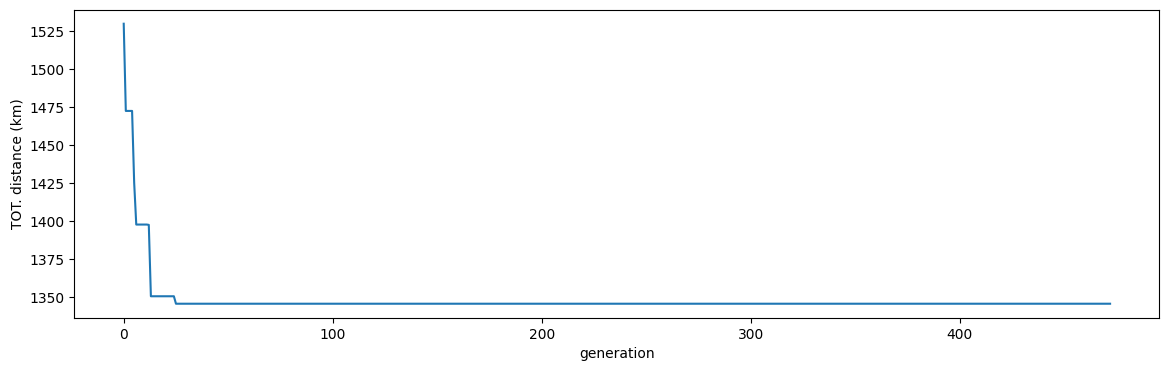

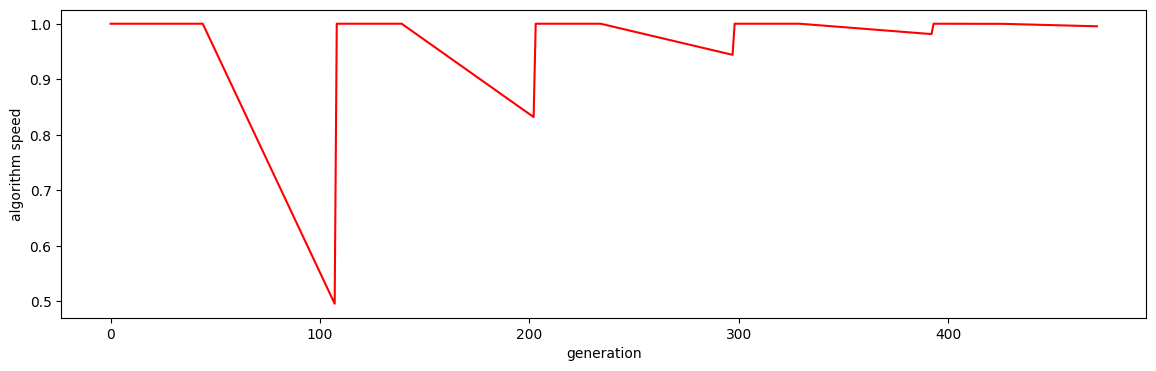

In [15]:

start_individual = Individual(greedy_solution)
population = [Individual.getRandom() if i<POPULATION_SIZE/2 else MOP.mutate(start_individual,strength_perc=10) for i in range(POPULATION_SIZE)] # start from greedy solution

ic(population[0].fitness())
history = [-population[0].fitness()]
speed_history = list()
        

for g in tqdm(range(MAX_GENERATIONS),position=0,desc="Generation"):
    check_improvement(g)
    progress = (g*SPEED)/(MAX_GENERATIONS)
    MUTATION_PROBABILITY = START_MUTATION_PROBABILITY * (1-progress) + END_MUTATION_PROBABILITY * progress
    offspring = list()
    for _ in range(OFFSPRING_SIZE):
        if rng.random()<MUTATION_PROBABILITY:
            p = parent_selection(population, tau=TAU)
            o = MOP.mutate(p,strength_perc=70*(1-progress)+1*progress)
        else:
            p1 = parent_selection(population, tau=TAU)
            p2 = parent_selection(population, tau=TAU)
            o = XOP(p1, p2)
        offspring.append(o)

    # SURVIVOR SELECTION
    population.extend(offspring)
    population.sort(key=lambda i: i.fitness(), reverse=True)
    population = population[:POPULATION_SIZE]
    history.append(-population[0].fitness())
    speed_history.append(SPEED)

ic(genome_cost.calls)
ic(population[0].fitness())
ic(population[0].genome())
plt.figure(figsize=(14, 4))
plt.plot(history)
plt.xlabel("generation")
plt.ylabel("TOT. distance (km)")
plt.figure(figsize=(14, 4))
plt.plot(np.array(speed_history),color="red")
plt.xlabel("generation")
plt.ylabel("algorithm speed");

Finally, i print some info about the retrieved solution:

In [16]:
solution = population[0]
sg = solution.genome()
hprint(f"Chosen TSP Path (TOT. of {-solution.fitness()} km):")
for i in range(GENOME_SIZE):
    j=i+1 if i+1<GENOME_SIZE else 0
    print(f"{i}.  {cities.loc[sg[i],"name"]} ---> {cities.loc[sg[j],"name"]} ({dist_matrix[sg[i],sg[j]]} km)")

Chosen TSP Path (TOT. of 1345.5449564733115 km):
0.  Port Olry ---> Luganville (52.02059578889833 km)
1.  Luganville ---> Norsup (67.09129555835896 km)
2.  Norsup ---> Lakatoro (2.458237855964039 km)
3.  Lakatoro ---> Vila (206.73999705909532 km)
4.  Vila ---> Isangel (223.00475078893413 km)
5.  Isangel ---> Longana (487.4945091162275 km)
6.  Longana ---> Sola (165.48511208446135 km)
7.  Sola ---> Port Olry (141.25045822137164 km)
